# Retinal Blood Vessel Segmentation with Modified LoG filter
In this notebook, we implement retinal blood vessel segmentation using an anisotropic Laplacian of Gaussian (ALoG) filter. The workflow includes:

1. Setup and data preparation
    - Import required libraries
    - Mount Google Drive and download DRIVE dataset
    - Convert image formats from GIF to TIF

2. Image preprocessing
    - Load and extract green channel from retinal images
    - Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    - Handle image masks and field of view (FOV) regions

3. Vessel enhancement using ALoG filter
    - Create directional anisotropic LoG filters
    - Apply multi-scale and multi-orientation filtering
    - Combine filter responses across scales and orientations

4. Parameter tuning
    - Grid search over CLAHE clip limit, sigma, and elongation parameters
    - Evaluate accuracy against ground truth annotations
    - Select optimal parameter combination

5. Results visualization
    - Display raw images, segmentation results and ground truth
    - Compare segmentation accuracy on test images

## 1. Setup and Imports

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from PIL import Image
from google.colab import drive
import glob
import itertools
import kagglehub
import shutil

In [ ]:
# Step 1: Mount Google Drive (adjust the path to where your DRIVE dataset is stored)
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Download the dataset
path = kagglehub.dataset_download("zionfuo/drive2004")
print("Path to dataset files:", path)

# Mount Google Drive (for Colab users)
drive.mount('/content/drive')

# Set target directory in your Google Drive
target_dir = "/content/drive/MyDrive/DRIVE_2004"

# Make sure the directory exists
os.makedirs(target_dir, exist_ok=True)

# Copy the files to Google Drive
shutil.copytree(path, target_dir, dirs_exist_ok=True)

print(f"Dataset copied to: {target_dir}")


Path to dataset files: /root/.cache/kagglehub/datasets/zionfuo/drive2004/versions/1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset copied to: /content/drive/MyDrive/DRIVE_2004


In [ ]:
def convert_gif_to_tif(src_folder, dest_folder):
    """Convert all .gif files in src_folder to .tif files in dest_folder, then delete the original .gif."""
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    for filename in os.listdir(src_folder):
        if filename.lower().endswith('.gif'):
            img_path = os.path.join(src_folder, filename)
            with Image.open(img_path) as img:
                base_name = os.path.splitext(filename)[0]
                new_filename = base_name + '.tif'
                new_path = os.path.join(dest_folder, new_filename)
                img.save(new_path)
            # Remove original gif file
            os.remove(img_path)


In [ ]:
def load_image(filepath):
    """
    Load an image using OpenCV and extract the green channel.
    Note: cv2.imread loads images in BGR order.
    """
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not load image: {filepath}")
    green_channel = img[:, :, 1]  # extract green channel
    return green_channel

In [ ]:
def load_mask(filepath):
    """
    Load a mask using PIL (to support .gif files), convert to a numpy array,
    and threshold it to create a binary mask.
    """
    with Image.open(filepath) as img:
        mask = np.array(img)
    # If the mask has 3 channels, take the first channel
    if mask.ndim == 3:
        mask = mask[:, :, 0]
    # Convert to binary mask (assuming values >128 are foreground)
    mask = (mask > 128).astype(np.uint8)
    return mask

In [ ]:
train_image_dir = "/content/drive/MyDrive/DRIVE_2004/DRIVE/training/images/"
train_fov_dir   = "/content/drive/MyDrive/DRIVE_2004/DRIVE/training/mask/"
train_mask_dir  = "/content/drive/MyDrive/DRIVE_2004/DRIVE/training/1st_manual/"

test_image_dir = "/content/drive/MyDrive/DRIVE_2004/DRIVE/test/images/"
test_fov_dir   = "/content/drive/MyDrive/DRIVE_2004/DRIVE/test/mask/"
test_mask_dir  = "/content/drive/MyDrive/DRIVE_2004/DRIVE/test/1st_manual/"
# Since OpenCV is not good with gif files
convert_gif_to_tif(train_fov_dir, train_fov_dir)
convert_gif_to_tif(test_fov_dir, test_fov_dir)
convert_gif_to_tif(train_mask_dir, train_mask_dir)
convert_gif_to_tif(test_mask_dir, test_mask_dir)

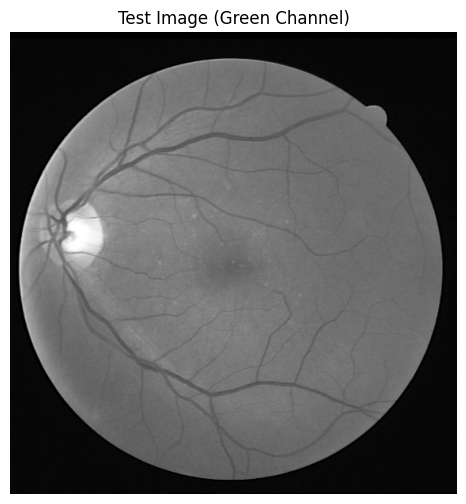

In [ ]:
# Test loading one image
train_image_path = train_image_dir + '21_training.tif'
train_image = load_image(train_image_path)
plt.figure(figsize=(6,6))
plt.imshow(train_image, cmap='gray')
plt.title("Test Image (Green Channel)")
plt.axis("off")
plt.show()

In [ ]:
# Ensure train_image is in uint8 format (adjust if your image is normalized between 0 and 1)
if train_image.dtype != np.uint8:
    if train_image.max() <= 1:
        train_image_uint8 = (train_image * 255).astype(np.uint8)
    else:
        train_image_uint8 = train_image.astype(np.uint8)
else:
    train_image_uint8 = train_image


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [9, 8, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 6],
       [7, 6, 6, ..., 0, 1, 1]], dtype=uint8)
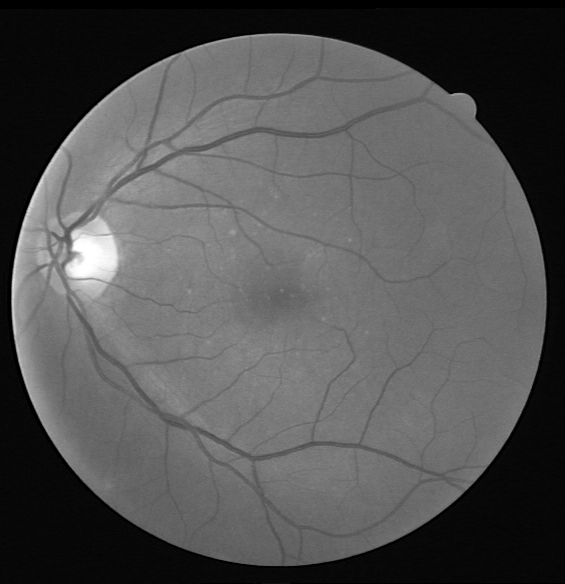

In [ ]:
train_image_uint8

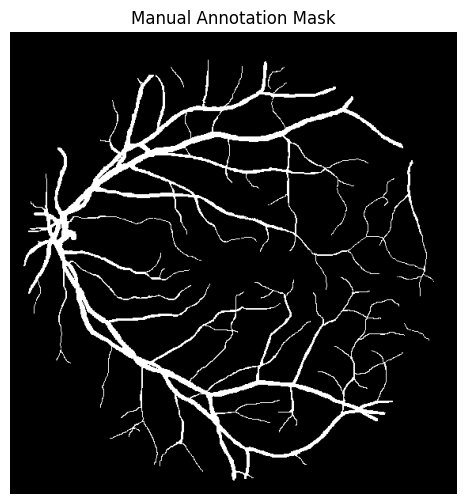

In [ ]:
# Test loading one manual annotation mask
mask_path = train_mask_dir + '21_manual1.tif'
mask = load_mask(mask_path)
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap='gray')
plt.title("Manual Annotation Mask")
plt.axis("off")
plt.show()

## 2. Image Preprocessing using CLAHE

CLAHE (Contrast Limited Adaptive Histogram Equalization) is applied to enhance vessel contrast while limiting noise amplification:

- `clipLimit=10.0`: Threshold for contrast limiting to prevent over-enhancement of noise
- `tileGridSize`: Image is divided into tiles sized (height/16 × width/16) for local histogram equalization
    - Adaptive tiling helps account for uneven illumination across the retinal image
    - Smaller tiles provide better local contrast enhancement for fine vessels

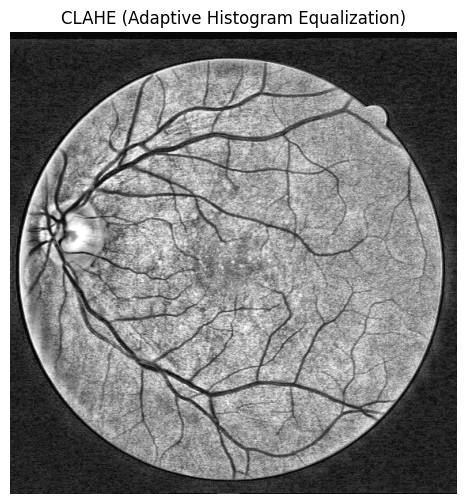

In [ ]:
# Create a CLAHE object with desired parameters
clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(int(np.floor(train_image_uint8.shape[0]/16).astype(int)),
                                                      int(np.floor(train_image_uint8.shape[1]/16).astype(int))))
clahe_img = clahe.apply(train_image_uint8)

# Display the CLAHE result
plt.figure(figsize=(6,6))
plt.imshow(clahe_img, cmap='gray')
plt.title("CLAHE (Adaptive Histogram Equalization)")
plt.axis("off")
plt.show()


## 3. Creating Anisotropic Laplacian of Gaussian (ALoG) filters

The ```create_directional_alog_filter``` function creates specialized filters designed to detect vessel-like structures in retinal images through several key mechanisms:

1. Directional Sensitivity:
- The filter can rotate to any angle (parameter `angle`) to match vessels running in different directions
- Uses coordinate transformation (Xr, Yr) to rotate the filter kernel, allowing detection of vessels at any orientation

2. Scale Adaptation:
- `sigma` controls the base width of the filter, matching different vessel thicknesses
- Multiple scales can be used to detect both thin and thick vessels
- The filter size automatically adjusts based on sigma to ensure proper coverage

3. Anisotropic Shape:
- Uses two different sigmas (sigma_short, sigma_long) to create elongated filters
- `elongation` parameter stretches the filter along vessel direction (sigma_long = elongation * sigma)
- This matches the natural elongated shape of blood vessels

4. Edge Detection Properties:
- Combines Gaussian smoothing with second-order derivatives (Laplacian)
- Produces strong responses at vessel boundaries
- The center-surround structure enhances vessel/background contrast

5. Zero-Mean Property:
- Filter is normalized to have zero mean (kernel -= kernel.mean())
- This makes it invariant to uniform background intensity
- Helps distinguish actual vessels from background variations

The visualization shows:
- Red/blue regions indicating positive/negative filter responses
- Elongated shape matching typical vessel structures
- Directional sensitivity shown by the filter's orientation


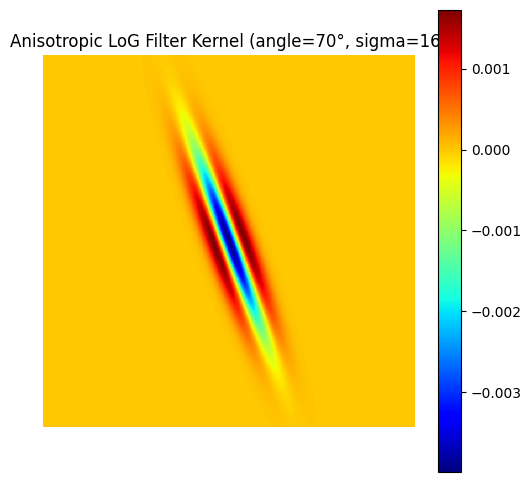

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_directional_alog_filter(angle, sigma, elongation=2.0, size=None):
    """
    Create an anisotropic Laplacian of Gaussian (ALoG) filter that is elongated
    along a specified direction to mimic the vessel shape.

    Parameters:
    - angle: Orientation of the filter in degrees.
    - sigma: The base standard deviation for the across-vessel direction.
    - elongation: Factor by which the long axis (along the vessel) is scaled.
                 sigma_long = elongation * sigma.
    - size: Size of the filter kernel. If None, it's determined from sigma_long.

    Returns:
    - kernel: The anisotropic LoG kernel.
    """
    sigma_short = sigma
    sigma_long = elongation * sigma

    if size is None:
        size = int(6 * sigma_long + 1)

    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, y)

    theta = np.deg2rad(angle)
    Xr = X * np.cos(theta) + Y * np.sin(theta)
    Yr = -X * np.sin(theta) + Y * np.cos(theta)

    term1 = (Xr**2 / sigma_long**4) + (Yr**2 / sigma_short**4)
    term2 = (1/sigma_long**2 + 1/sigma_short**2)
    gaussian = np.exp(-(Xr**2/(2*sigma_long**2) + Yr**2/(2*sigma_short**2)))
    kernel = (term1 - term2) * gaussian

    kernel -= kernel.mean()
    return kernel

# Choose parameters for visualization:
angle = 70           # angle in degrees
sigma = 16          # base sigma value
elongation_factor = 7

# Generate the anisotropic LoG filter kernel
kernel = create_directional_alog_filter(angle, sigma, elongation=elongation_factor)

# Display the kernel using imshow
plt.figure(figsize=(6, 6))
plt.imshow(kernel, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.title(f"Anisotropic LoG Filter Kernel (angle={angle}°, sigma={sigma})")
plt.axis("off")
plt.show()


## 4. Multi-Scale and Multi-Orientation Filter Response Combination

The code below combines filter responses across multiple scales and orientations through nested loops:

1. **Orientation Loop**:
    - Iterates through 18 angles from 0° to 180° to detect vessels at different orientations
    - For each angle, creates and applies an anisotropic LoG filter
    - Responses below an adaptive threshold are zeroed out to reduce artifacts

2. **Elongation Loop**:
    - Applies different elongation factors to vary filter shape
    - Higher elongation produces more elongated filters better suited for vessel detection
    - Responses from different elongations are combined using maximum operation

3. **Scale Loop**:
    - Processes different sigma values to detect vessels of varying widths
    - For each scale, combines responses across all orientations and elongations
    - Final vessel map is generated by taking maximum response across all scales

4. **Response Combination**:
    - Maximum operation preserves strongest vessel responses
    - Absolute values ensure both bright and dark vessels are detected
    - FOV mask is applied to limit detection to valid image regions

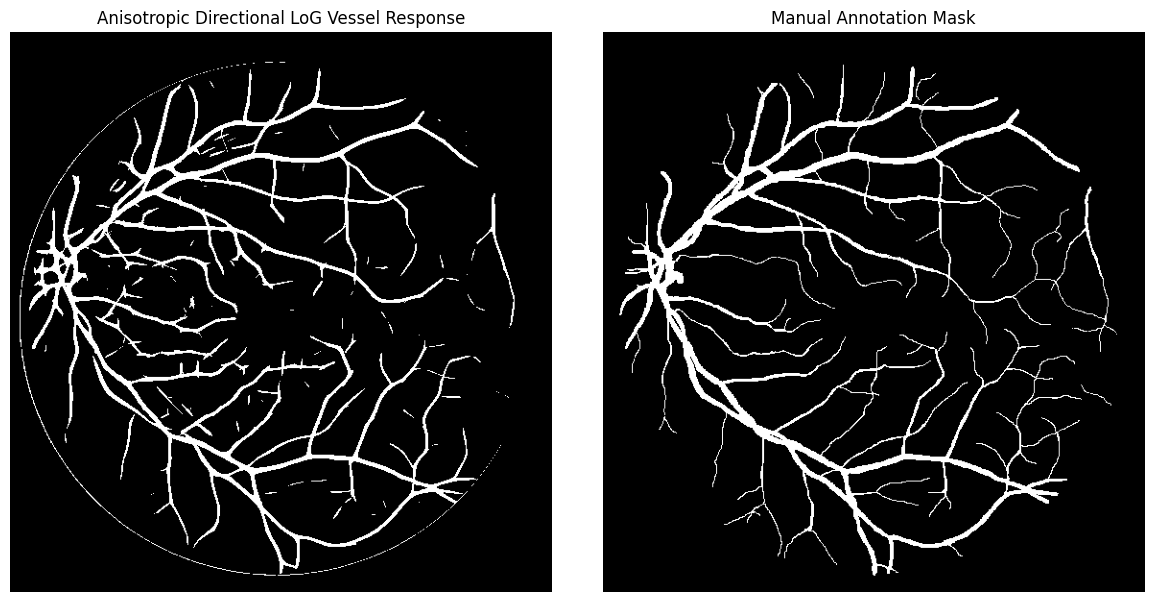

In [ ]:
# Example parameters:
num_orientations = 18  # Number of directional filters (covering 0° to 180°)
angles = np.linspace(0, 180, num_orientations, endpoint=False)

# Define sigma values for scale invariance (different vessel widths)
sigma_values = [2.0]

# Define a set of elongation factors that will be applied to each sigma
elongation_factors = [3.0]

# Define a factor for thresholding artifact responses:
artifact_threshold_factor = 1.0

scale_responses = []

# For each sigma, combine responses from all elongation factors and directions.
for sigma in sigma_values:
    responses_for_sigma = []  # To store responses for all elongations and angles for this sigma
    for elongation in elongation_factors:
        for angle in angles:
            # Create the anisotropic directional LoG filter for current parameters.
            kernel = create_directional_alog_filter(angle, sigma, elongation=elongation)
            # Filter the image with the directional ALoG filter.
            response = cv2.filter2D(clahe_img, -1, kernel)

            # Apply adaptive thresholding based on a fraction of the max absolute response.
            abs_response = np.abs(response)
            threshold = artifact_threshold_factor * np.max(abs_response)
            response[abs_response < threshold] = 0

            responses_for_sigma.append(response)

    # Combine responses for the current sigma across all elongations and angles.
    combined_sigma_response = np.max(np.abs(np.array(responses_for_sigma)), axis=0)
    scale_responses.append(combined_sigma_response)

# Finally, combine responses across scales (sigma values) using the maximum response per pixel.
final_response = np.max(np.array(scale_responses), axis=0)
train_fov_path = train_fov_dir + '21_training_mask.tif'
train_fov = load_image(train_fov_path)

# Normalize the FOV mask to have values between 0 and 1 (if needed)
# (Assuming the mask values are in the range [0, 255])
train_fov_norm = train_fov / 255.0

# Multiply the raw image with the normalized FOV mask
final_response = final_response * train_fov_norm
# Display the final vessel-like response map along the true annotation.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Test loading one manual annotation mask
mask_path = train_mask_dir + '21_manual1.tif'
mask = load_mask(mask_path)
# Display both images side by side
# First image
axes[0].imshow(final_response, cmap='gray')
axes[0].set_title("Anisotropic Directional LoG Vessel Response")
axes[0].axis("off")

# Second image
axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Manual Annotation Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## 5. Parameter Tuning Process

The code performs grid search over 3 key parameters to optimize vessel segmentation:

1. **CLAHE Clip Limit**: [3.0, 5.0, 7.0, 10.0, 12.0]
    - Controls contrast enhancement intensity
    - Higher values allow more contrast enhancement but may amplify noise

2. **Sigma Values**: [1.0, 1.5, 2.0, 2.5, 3.0]
    - Controls base filter scale/width
    - Smaller sigma detects fine vessels, larger sigma for thick vessels

3. **Elongation Factors**: [2.5, 3.0, 3.5, 4.0]
    - Determines filter aspect ratio
    - Higher values create more elongated filters better suited for vessels

For each parameter combination:
- Processes all training images
- Computes pixel-wise accuracy against ground truth
- Averages accuracy across training set
- Tracks best performing parameter set

Fixed Parameters:
- 18 filter orientations (0° to 180°)
- Artifact threshold factor = 1.0

In [ ]:
# --- Load images and pre-process ---
# --- Define your directories ---
# (Update these paths as needed)
train_image_dir = "/content/drive/MyDrive/DRIVE_2004/DRIVE/training/images/"
train_fov_dir   = "/content/drive/MyDrive/DRIVE_2004/DRIVE/training/mask/"
train_mask_dir  = "/content/drive/MyDrive/DRIVE_2004/DRIVE/training/1st_manual/"

# --- List and sort file names in each directory ---
train_image_files = sorted(os.listdir(train_image_dir))
train_fov_files   = sorted(os.listdir(train_fov_dir))
train_mask_files  = sorted(os.listdir(train_mask_dir))

# --- Set candidate parameters for tuning ---
num_orientations = 18  # directional filters (covering 0° to 180°)
angles = np.linspace(0, 180, num_orientations, endpoint=False)

# Candidate values for the CLAHE clipLimit
clipLimit_candidates = [3.0, 5.0, 7.0, 10.0, 12.0]

# Candidate sigma values (scale of vessel width)
sigma_candidates = [1.0, 1.5, 2.0, 2.5, 3.0]

# Candidate elongation factors (shape of the filter)
elongation_candidates = [2.5, 3.0, 3.5, 4.0]

# Fixed artifact threshold factor (no tuning required)
artifact_thresh_fixed = 1.0

# To store global results for each parameter combination
global_results = []

# --- Grid search over all parameter combinations (excluding artifact_thresh) ---
for clipLimit, sigma, elongation in itertools.product(
        clipLimit_candidates, sigma_candidates, elongation_candidates):

    # List to store the accuracy for each image for the current parameter combination.
    accuracies = []

    # Process each training image
    for img_file, fov_file, mask_file in zip(train_image_files, train_fov_files, train_mask_files):

        # Construct file paths
        image_path = os.path.join(train_image_dir, img_file)
        fov_path   = os.path.join(train_fov_dir, fov_file)
        mask_path  = os.path.join(train_mask_dir, mask_file)

        # --- Load and preprocess the image ---
        image = load_image(image_path)
        if image.dtype != np.uint8:
            if image.max() <= 1:
                image_uint8 = (image * 255).astype(np.uint8)
            else:
                image_uint8 = image.astype(np.uint8)
        else:
            image_uint8 = image

        # Define tileGridSize based on image dimensions
        tileGridSize = (int(np.floor(image_uint8.shape[0] / 16)),
                        int(np.floor(image_uint8.shape[1] / 16)))

        # Apply CLAHE using current clipLimit candidate
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        clahe_img = clahe.apply(image_uint8)

        # --- Load FOV mask and ground-truth mask ---
        fov = load_image(fov_path)
        fov_norm = fov / 255.0
        gt_mask = load_mask(mask_path)
        gt_mask_binary = (gt_mask > 0).astype(np.uint8)

        # --- Apply the directional filter bank ---
        responses = []
        for angle in angles:
            kernel = create_directional_alog_filter(angle, sigma, elongation=elongation)
            response = cv2.filter2D(clahe_img, -1, kernel)

            # Adaptive thresholding: zero-out responses below fixed threshold * max(abs(response))
            abs_response = np.abs(response)
            threshold = artifact_thresh_fixed * np.max(abs_response)
            response[abs_response < threshold] = 0

            responses.append(response)

        # Combine responses across directions (maximum absolute response)
        combined_response = np.max(np.abs(np.array(responses)), axis=0)

        # Normalize and perform Otsu thresholding to obtain a binary segmentation
        final_response_norm = cv2.normalize(combined_response, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        ret, otsu_thresh = cv2.threshold(final_response_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Apply the FOV mask
        seg = otsu_thresh * fov_norm
        seg_binary = (seg > 0).astype(np.uint8)

        # --- Compute accuracy (pixel-wise comparison) ---
        accuracy = np.sum(seg_binary == gt_mask_binary) / seg_binary.size
        accuracies.append(accuracy)

    # Compute the average accuracy across all images for this parameter combination
    avg_accuracy = np.mean(accuracies)
    global_results.append({
        'clipLimit': clipLimit,
        'sigma': sigma,
        'elongation': elongation,
        'avg_accuracy': avg_accuracy
    })

    print(f"Params: clipLimit={clipLimit}, sigma={sigma}, elongation={elongation}, "
          f"Artifact Threshold Factor={artifact_thresh_fixed}, Avg Accuracy={avg_accuracy:.3f}")

# --- Identify and print the best parameter combination across the training set ---
best_params = max(global_results, key=lambda x: x['avg_accuracy'])
print("\nBest Parameters Across Training Set:")
print(f"ClipLimit: {best_params['clipLimit']}, Sigma: {best_params['sigma']}, "
      f"Elongation: {best_params['elongation']}, Artifact Threshold Factor: {artifact_thresh_fixed}")
print(f"Average Accuracy: {best_params['avg_accuracy']:.3f}")


Params: clipLimit=3.0, sigma=1.0, elongation=2.5, Artifact Threshold Factor=1.0, Avg Accuracy=0.915
Params: clipLimit=3.0, sigma=1.0, elongation=3.0, Artifact Threshold Factor=1.0, Avg Accuracy=0.920
Params: clipLimit=3.0, sigma=1.0, elongation=3.5, Artifact Threshold Factor=1.0, Avg Accuracy=0.924
Params: clipLimit=3.0, sigma=1.0, elongation=4.0, Artifact Threshold Factor=1.0, Avg Accuracy=0.930
Params: clipLimit=3.0, sigma=1.5, elongation=2.5, Artifact Threshold Factor=1.0, Avg Accuracy=0.927
Params: clipLimit=3.0, sigma=1.5, elongation=3.0, Artifact Threshold Factor=1.0, Avg Accuracy=0.932
Params: clipLimit=3.0, sigma=1.5, elongation=3.5, Artifact Threshold Factor=1.0, Avg Accuracy=0.936
Params: clipLimit=3.0, sigma=1.5, elongation=4.0, Artifact Threshold Factor=1.0, Avg Accuracy=0.942
Params: clipLimit=3.0, sigma=2.0, elongation=2.5, Artifact Threshold Factor=1.0, Avg Accuracy=0.933
Params: clipLimit=3.0, sigma=2.0, elongation=3.0, Artifact Threshold Factor=1.0, Avg Accuracy=0.938


## 6. Visualize Predictions

Display a random test image along with the ground truth mask and predictions from the test set.


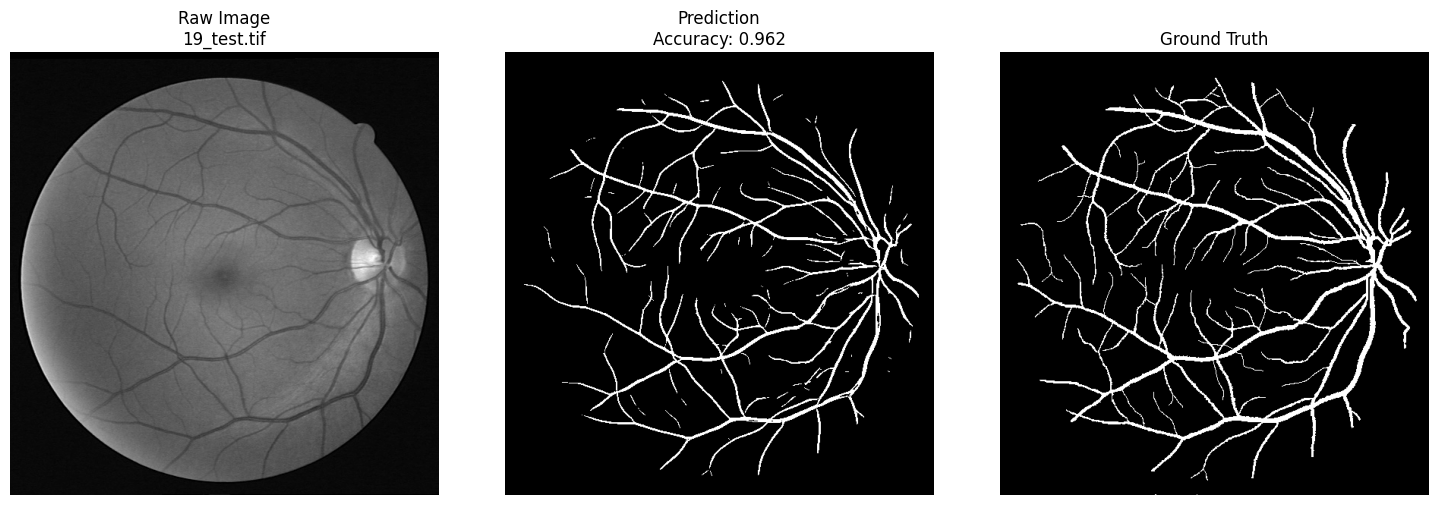

In [ ]:
# --- Define Test Directories ---
test_image_dir = "/content/drive/MyDrive/DRIVE_2004/DRIVE/test/images/"
test_fov_dir   = "/content/drive/MyDrive/DRIVE_2004/DRIVE/test/mask/"
test_mask_dir  = "/content/drive/MyDrive/DRIVE_2004/DRIVE/test/1st_manual/"

# --- List and sort file names in each directory ---
test_image_files = sorted(os.listdir(test_image_dir))
test_fov_files   = sorted(os.listdir(test_fov_dir))
test_mask_files  = sorted(os.listdir(test_mask_dir))

# --- Tuned Parameters (Update with your tuned values) ---
tuned_clipLimit = 7.0      # example value
tuned_sigma = 1.5          # example value
tuned_elongation = 3.0     # example value
artifact_thresh_fixed = 1.0

# --- Define the directional filter settings ---
num_orientations = 18  # directional filters (covering 0° to 180°)
angles = np.linspace(0, 180, num_orientations, endpoint=False)

# --- Placeholder for results (to store segmentation, accuracy and image info) ---
results = []

# --- Loop over each test image ---
for img_file, fov_file, mask_file in zip(test_image_files, test_fov_files, test_mask_files):

    # Construct file paths
    image_path = os.path.join(test_image_dir, img_file)
    fov_path   = os.path.join(test_fov_dir, fov_file)
    mask_path  = os.path.join(test_mask_dir, mask_file)

    # --- Load and preprocess the raw image ---
    image = load_image(image_path)
    if image.dtype != np.uint8:
        if image.max() <= 1:
            image_uint8 = (image * 255).astype(np.uint8)
        else:
            image_uint8 = image.astype(np.uint8)
    else:
        image_uint8 = image

    # Define tileGridSize for CLAHE based on image dimensions
    tileGridSize = (int(np.floor(image_uint8.shape[0] / 16)),
                    int(np.floor(image_uint8.shape[1] / 16)))

    # Apply CLAHE with tuned clipLimit
    clahe = cv2.createCLAHE(clipLimit=tuned_clipLimit, tileGridSize=tileGridSize)
    clahe_img = clahe.apply(image_uint8)

    # --- Load FOV mask and ground-truth mask ---
    fov = load_image(fov_path)
    fov_norm = fov / 255.0
    gt_mask = load_mask(mask_path)
    gt_mask_binary = (gt_mask > 0).astype(np.uint8)

    # --- Apply the directional filter bank ---
    responses = []
    for angle in angles:
        kernel = create_directional_alog_filter(angle, tuned_sigma, elongation=tuned_elongation)
        response = cv2.filter2D(clahe_img, -1, kernel)

        # Zero-out responses below the fixed threshold (artifact_thresh_fixed * max(abs(response)))
        abs_response = np.abs(response)
        threshold = artifact_thresh_fixed * np.max(abs_response)
        response[abs_response < threshold] = 0
        responses.append(response)

    # Combine responses across all directions (maximum absolute response)
    combined_response = np.max(np.abs(np.array(responses)), axis=0)

    # Normalize and apply Otsu thresholding to generate the binary segmentation
    final_response_norm = cv2.normalize(combined_response, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    ret, otsu_thresh = cv2.threshold(final_response_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Dilate the FOV mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))  # Adjust kernel size as needed
    fov_dilated = cv2.erode(fov_norm.astype(np.uint8), kernel)

    # Normalize the dilated FOV mask back to [0,1]
    fov_dilated_norm = fov_dilated / 255.0

    # Now apply the dilated FOV mask on your segmentation
    seg = otsu_thresh * fov_dilated_norm
    # Apply the FOV mask to obtain the final segmentation
    # seg = otsu_thresh * fov_norm
    seg_binary = (seg > 0).astype(np.uint8)

    # --- Compute pixel-wise accuracy ---
    accuracy = np.sum(seg_binary == gt_mask_binary) / seg_binary.size

    # Append results for this image
    results.append({
        'img_file': img_file,
        'raw_image': image_uint8,
        'segmentation': seg_binary,
        'ground_truth': gt_mask_binary,
        'accuracy': accuracy
    })

# --- Sort results by accuracy (highest first) and select top 10 samples ---
results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)
top_results = results_sorted[:1]

# --- Visualization of Raw Image, Segmentation, and Ground Truth ---
for res in top_results:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(res['raw_image'], cmap='gray')
    axes[0].set_title(f"Raw Image\n{res['img_file']}")
    axes[0].axis('off')

    axes[1].imshow(res['segmentation'], cmap='gray')
    axes[1].set_title(f"Prediction\nAccuracy: {res['accuracy']:.3f}")
    axes[1].axis('off')

    axes[2].imshow(res['ground_truth'], cmap='gray')
    axes[2].set_title("Ground Truth")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()